In [86]:
import pandas as pd
import numpy as np
import os
import time
import copy
import pathlib, tempfile

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from graphviz import Digraph
from joblib import Parallel, delayed
from scipy import stats

from survivors import metrics as metr
from survivors import constants as cnt
from survivors import criteria as crit
from numba import njit, jit, int32, float64
from lifelines import KaplanMeierFitter, NelsonAalenFitter

import cProfile
import pstats

%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [4]:
@njit('f8(f8[:], f8[:], i8[:], i8[:], i8)', cache=True)
def lr_statistic(dur_1, dur_2, cens_1, cens_2, weightings):
    times = np.unique(np.hstack((dur_1, dur_2)))
    dur_1 = np.searchsorted(times, dur_1) + 1
    dur_2 = np.searchsorted(times, dur_2) + 1
    times_range = np.array([1, times.shape[0]], dtype=np.int32)

    bins = times_range[1] - times_range[0] + 1
    n_1_j = np.histogram(dur_1, bins=bins, range=times_range)[0]
    n_2_j = np.histogram(dur_2, bins=bins, range=times_range)[0]
    O_1_j = np.histogram(dur_1 * cens_1, bins=bins, range=times_range)[0]
    O_2_j = np.histogram(dur_2 * cens_2, bins=bins, range=times_range)[0]

    N_1_j = np.cumsum(n_1_j[::-1])[::-1]
    N_2_j = np.cumsum(n_2_j[::-1])[::-1]
    ind = np.where(N_1_j * N_2_j != 0)
    N_1_j = N_1_j[ind]
    N_2_j = N_2_j[ind]
    O_1_j = O_1_j[ind]
    O_2_j = O_2_j[ind]

    N_j = N_1_j + N_2_j
    O_j = O_1_j + O_2_j
    E_1_j = N_1_j * O_j / N_j
    res = np.zeros((N_j.shape[0], 3), dtype=np.float32)
    res[:, 1] = O_1_j - E_1_j
    res[:, 2] = E_1_j * (N_j - O_j) * N_2_j / (N_j * (N_j - 1))
    res[:, 0] = 1.0
    # if np.any(N_j <= 1):
    #     return 0.0
    if weightings == 2:
        res[:, 0] = N_j
    elif weightings == 3:
        res[:, 0] = np.sqrt(N_j)
    elif weightings == 4:
        res[:, 0] = np.cumprod((1.0 - O_j / (N_j + 1)))
    logrank = np.power((res[:, 0] * res[:, 1]).sum(), 2) / ((res[:, 0] * res[:, 0] * res[:, 2]).sum())
    return logrank


def weight_lr_fast(dur_A, dur_B, cens_A=None, cens_B=None, weightings=""):
    try:
        if cens_A is None:
            cens_A = np.ones(dur_A.shape[0])
        if cens_B is None:
            cens_B = np.ones(dur_B.shape[0])
        d = {"logrank": 1, "wilcoxon": 2, "tarone-ware": 3, "peto": 4}
        weightings = d.get(weightings, 1)
        logrank = lr_statistic(dur_A.astype("float64"),
                               dur_B.astype("float64"),
                               cens_A.astype("int64"),
                               cens_B.astype("int64"),
                               np.int64(weightings))
        return logrank
    except Exception as err:
        return 0.0
    
def logrank(durations_A, durations_B, event_observed_A=None, event_observed_B=None):
    return weight_lr_fast(durations_A, durations_B, event_observed_A, event_observed_B)

In [484]:
def optimal_criter_split(arr_nan, left, right, criterion):
    none_to = 0
    max_stat_val = 1.0
    if arr_nan.shape[1] > 0:
        left_and_nan = np.hstack([left, arr_nan])
        right_and_nan = np.hstack([right, arr_nan])
        a = criterion(left_and_nan[1], right[1], left_and_nan[0], right[0])
        b = criterion(left[1], right_and_nan[1], left[0], right_and_nan[0])
        # Nans move to a leaf with maximal statistical value
        none_to = int(a < b)
        max_stat_val = max(a, b)
#         print(a, b)
    else:
        max_stat_val = criterion(left[1], right[1], left[0], right[0])
    return (max_stat_val, none_to)


def get_attrs(max_stat_val, values, none_to, l_sh, r_sh, nan_sh):
    attrs = dict()
    attrs["stat_val"] = max_stat_val
    attrs["values"] = values
    if none_to:
        attrs["pos_nan"] = [0, 1]
        attrs["min_split"] = min(l_sh, r_sh+nan_sh)
    else:
        attrs["pos_nan"] = [1, 0]
        attrs["min_split"] = min(l_sh+nan_sh, r_sh)
    return attrs


def get_cont_attrs(uniq_set, arr_notnan, arr_nan, min_samples_leaf, criterion, 
                   signif_val, thres_cont_bin_max):
    if uniq_set.shape[0] > thres_cont_bin_max:
        uniq_set = np.quantile(arr_notnan[0], [i/float(thres_cont_bin_max) for i in range(1, thres_cont_bin_max)])
    else:  # Set intermediate points
        uniq_set = (uniq_set[:-1] + uniq_set[1:])*0.5
    uniq_set = list(set(np.round(uniq_set, 3)))
    attr_dicts = []
    for value in uniq_set:
        # Filter by attr value
        ind = arr_notnan[0] >= value
        left = arr_notnan[1:, np.where(ind)[0]]  #.astype(np.int32)  # inaccuracy in stat values
        right = arr_notnan[1:, np.where(~ind)[0]]  # .astype(np.int32)
        
        if min(left.shape[1], right.shape[1]) <= min_samples_leaf:
            continue
        max_stat_val, none_to = optimal_criter_split(arr_nan, left, right, criterion)
        if max_stat_val >= signif_val:
            attr_loc = get_attrs(max_stat_val, value, none_to,
                                 left.shape[1], right.shape[1], arr_nan.shape[1])
            attr_dicts.append(attr_loc)
#         print(value, max_stat_val)
    return attr_dicts


def get_categ_attrs(uniq_set, arr_notnan, arr_nan, min_samples_leaf, criterion, signif_val):
    attr_dicts = []
    pairs_uniq = power_set_nonover(uniq_set)
    for l, r in pairs_uniq:
        left = arr_notnan[1:, np.isin(arr_notnan[0], l)].astype(np.int32)
        right = arr_notnan[1:, np.isin(arr_notnan[0], r)].astype(np.int32)
        if min(left.shape[1], right.shape[1]) <= min_samples_leaf:
            continue
        max_stat_val, none_to = optimal_criter_split(arr_nan, left, right, criterion)
        if max_stat_val >= signif_val:
            attr_loc = get_attrs(max_stat_val, [list(l), list(r)], none_to,
                                 left.shape[1], right.shape[1], arr_nan.shape[1])
            attr_dicts.append(attr_loc)
    return attr_dicts


def best_attr_split(arr, criterion="logrank", type_attr="cont", thres_cont_bin_max=100,
                         signif=1.0, signif_stat=0.0, min_samples_leaf=10, bonf=True, verbose=0, **kwargs):
#     criterion = crit.CRITERIA_DICT.get(criterion, None)
    best_attr = {"stat_val": signif_stat, "p_value": signif,
                 "sign_split": 0, "values": [], "pos_nan": [1, 0]}
    if arr.shape[1] < 2*min_samples_leaf:
        return best_attr

    ind = np.isnan(arr[0])
    arr_nan = arr[1:, np.where(ind)[0]].astype(np.int32)
    arr_notnan = arr[:, np.where(~ind)[0]]
    
    if type_attr == "woe":
        arr_notnan[0], descr_np = transform_woe(arr_notnan[0], arr_notnan[1])
        
    
    uniq_set = np.unique(arr_notnan[0])
    
    if type_attr == "categ" and uniq_set.shape[0] > 0:
        attr_dicts = get_categ_attrs(uniq_set, arr_notnan, arr_nan,
                                     min_samples_leaf, logrank, signif_stat)
    else:
        attr_dicts = get_cont_attrs(uniq_set, arr_notnan, arr_nan,
                                    min_samples_leaf, logrank, signif_stat, thres_cont_bin_max)
    
    if len(attr_dicts) == 0:
        return best_attr
    best_attr = max(attr_dicts, key=lambda x: x["stat_val"])
    best_attr["p_value"] = stats.chi2.sf(best_attr["stat_val"], df=1)
    best_attr["sign_split"] = len(attr_dicts)
    if best_attr["sign_split"] > 0:
        if type_attr == "cont":
            best_attr["values"] = [f" >= {best_attr['values']}", f" < {best_attr['values']}"]
        elif type_attr == "categ":
            best_attr["values"] = [f" in {e}" for e in best_attr["values"]]
        elif type_attr == "woe":
            ind = descr_np[1] >= best_attr["values"]
            l, r = list(descr_np[0, np.where(ind)[0]]), list(descr_np[0, np.where(~ind)[0]])
            best_attr["values"] = [f" in {e}" for e in [l, r]]
        if bonf:
            best_attr["p_value"] *= best_attr["sign_split"]
        if verbose > 0:
            print(best_attr["p_value"], len(uniq_set))
    return best_attr

### NEW SPLITTING

In [434]:
@njit('f8(u4[:], u4[:], u4[:], u4[:], u4)', cache=True)
def lr_hist_statistic(time_hist_1, time_hist_2, cens_hist_1, cens_hist_2, weightings):
    N_1_j = np.cumsum(time_hist_1[::-1])[::-1]
    N_2_j = np.cumsum(time_hist_2[::-1])[::-1]
    ind = np.where(N_1_j * N_2_j != 0)
    N_1_j = N_1_j[ind]
    N_2_j = N_2_j[ind]
    O_1_j = cens_hist_1[ind]
    O_2_j = cens_hist_2[ind]

    N_j = N_1_j + N_2_j
    O_j = O_1_j + O_2_j
    E_1_j = N_1_j * O_j / N_j
    res = np.zeros((N_j.shape[0], 3), dtype=np.float32)
    res[:, 1] = O_1_j - E_1_j
    res[:, 2] = E_1_j * (N_j - O_j) * N_2_j / (N_j * (N_j - 1))
    res[:, 0] = 1.0
    
    if weightings == 2:
        res[:, 0] = N_j
    elif weightings == 3:
        res[:, 0] = np.sqrt(N_j)
    elif weightings == 4:
        res[:, 0] = np.cumprod((1.0 - O_j / (N_j + 1)))
    stat_val = np.power((res[:, 0] * res[:, 1]).sum(), 2) / ((res[:, 0] * res[:, 0] * res[:, 2]).sum())
    return stat_val

def weight_hist_stat(time_hist_1, time_hist_2, cens_hist_1=None, cens_hist_2=None, weightings=""):
    try:
        if cens_hist_1 is None:
            cens_hist_1 = time_hist_1
        if cens_hist_2 is None:
            cens_hist_2 = time_hist_2
        d = {"logrank": 1, "wilcoxon": 2, "tarone-ware": 3, "peto": 4}
        weightings = d.get(weightings, 1)
        logrank = lr_hist_statistic(time_hist_1.astype("uint32"),
                                    time_hist_2.astype("uint32"),
                                    cens_hist_1.astype("uint32"),
                                    cens_hist_2.astype("uint32"),
                                    np.uint32(weightings))
        return logrank
    except Exception as err:
        return 0.0
    
def logrank_hist(time_hist_1, time_hist_2, cens_hist_1=None, cens_hist_2=None):
    return weight_hist_stat(time_hist_1, time_hist_2, cens_hist_1, cens_hist_2)

def optimal_criter_split_hist(left_time_hist, left_cens_hist, 
                         right_time_hist, right_cens_hist,
                         na_time_hist, na_cens_hist, criterion):
    none_to = 0
    max_stat_val = 1.0
    if na_time_hist.shape[0] > 0:
        a = criterion(left_time_hist + na_time_hist, right_time_hist, 
                      left_cens_hist + na_cens_hist, right_cens_hist)
        b = criterion(left_time_hist, right_time_hist + na_time_hist, 
                      left_cens_hist, right_cens_hist + na_cens_hist)
        # Nans move to a leaf with maximal statistical value
        none_to = int(a < b)
        max_stat_val = max(a, b)
#         print(a, b)
    else:
        max_stat_val = criterion(left_time_hist, right_time_hist, 
                                 left_cens_hist, right_cens_hist)
    return (max_stat_val, none_to)

def split_time_to_bins(time):
    return np.searchsorted(np.unique(time), time)


def get_attrs(max_stat_val, values, none_to, l_sh, r_sh, nan_sh):
    attrs = dict()
    attrs["stat_val"] = max_stat_val
    attrs["values"] = values
    if none_to:
        attrs["pos_nan"] = [0, 1]
        attrs["min_split"] = min(l_sh, r_sh+nan_sh)
    else:
        attrs["pos_nan"] = [1, 0]
        attrs["min_split"] = min(l_sh+nan_sh, r_sh)
    return attrs

In [472]:
def hist_best_attr_split(arr, criterion="logrank", type_attr="cont", thres_cont_bin_max=100,
                         signif=1.0, signif_stat=0.0, min_samples_leaf=10, bonf=True, verbose=0, **kwargs):
    criterion = crit.CRITERIA_DICT.get(criterion, None)
    best_attr = {"stat_val": signif_stat, "p_value": signif,
                 "sign_split": 0, "values": [], "pos_nan": [1, 0]}
    if arr.shape[1] < 2*min_samples_leaf:
        return best_attr
    vals = arr[0]
    cens = arr[1]
    dur = arr[2]
    
    dur = split_time_to_bins(dur)
    time_bins = np.unique(dur)
    ind = np.isnan(vals)

    # split nan and not-nan
    dur_notna = dur[~ind]
    cens_notna = cens[~ind]
    vals_notna = vals[~ind]

    # find splitting values
    uniq_set = np.unique(vals_notna)
    if uniq_set.shape[0] > thres_cont_bin_max:
        uniq_set = np.quantile(vals_notna, [i/float(thres_cont_bin_max) for i in range(1, thres_cont_bin_max)])
    else:
        uniq_set = (uniq_set[:-1] + uniq_set[1:])*0.5
    uniq_set = np.unique(np.round(uniq_set, 3))
    index_vals_bin = np.digitize(vals_notna, uniq_set)

    # find global hist by times
    na_time_hist = np.bincount(dur[ind])
    na_cens_hist = np.bincount(dur[ind], weights=cens[ind])
#     print(na_time_hist)
#     print(na_cens_hist)

    right_time_hist = np.bincount(dur_notna)
    right_cens_hist = np.bincount(dur_notna, weights=cens_notna)
    left_time_hist = np.zeros_like(right_cens_hist, dtype=np.int32)
    left_cens_hist = left_time_hist.copy()
    
    num_nan = ind.sum()
    num_r = dur_notna.shape[0]
    num_l = 0

    # for each split values get branches
    attr_dicts = []
    for u in np.unique(index_vals_bin)[:-1]:
        curr_mask = index_vals_bin == u
        curr_n = curr_mask.sum()
        curr_time_hist = np.bincount(dur_notna, weights=curr_mask).astype("int32")
        curr_cens_hist = np.bincount(dur_notna, weights=cens_notna*curr_mask).astype("int32")
        left_time_hist += curr_time_hist
        left_cens_hist += curr_cens_hist
        right_time_hist -= curr_time_hist
        right_cens_hist -= curr_cens_hist
        num_l += curr_n
        num_r -= curr_n
        
        if min(num_l, num_r) <= min_samples_leaf:
            continue
        max_stat_val, none_to = optimal_criter_split_hist(left_time_hist, left_cens_hist, 
                                                     right_time_hist, right_cens_hist,
                                                     na_time_hist, na_cens_hist, logrank_hist)
        
        if max_stat_val >= signif_stat:
            attr_loc = get_attrs(max_stat_val, uniq_set[u], none_to, num_l, num_r, num_nan)
            attr_dicts.append(attr_loc)
#         print(uniq_set[u], max_stat_val)
    
    if len(attr_dicts) == 0:
        return best_attr
    best_attr = max(attr_dicts, key=lambda x: x["stat_val"])
    best_attr["p_value"] = stats.chi2.sf(best_attr["stat_val"], df=1)
    best_attr["sign_split"] = len(attr_dicts)
    if best_attr["sign_split"] > 0:
        if type_attr == "cont":
            best_attr["values"] = [f" <= {best_attr['values']}", f" > {best_attr['values']}"]
        elif type_attr == "categ":
            best_attr["values"] = [f" in {e}" for e in best_attr["values"]]
        elif type_attr == "woe":
            ind = descr_np[1] >= best_attr["values"]
            l, r = list(descr_np[0, np.where(ind)[0]]), list(descr_np[0, np.where(~ind)[0]])
            best_attr["values"] = [f" in {e}" for e in [l, r]]
        if bonf:
            best_attr["p_value"] *= best_attr["sign_split"]
        if verbose > 0:
            print(best_attr["p_value"], len(uniq_set))
    return best_attr

In [520]:
def transform_woe(x_feat, y):
    a = np.vstack([x_feat, y]).T
    a = a[a[:, 0] == a[:, 0]]
    
    N_T = y.shape[0]
    N_D = y.sum()
    N_D_ = N_T - y.sum()

    df_woe_iv = pd.crosstab(a[:, 0], a[:, 1])
    all_0 = df_woe_iv[0].sum()
    all_1 = df_woe_iv[1].sum()

    df_woe_iv["p_bd"] = (df_woe_iv[1] + 1e-5) / (N_D + 1e-5)
    df_woe_iv["p_bd_"] = (df_woe_iv[0] + 1e-5) / (N_D_ + 1e-5)
    df_woe_iv["p_b_d"] = (all_1 - df_woe_iv[1] + 1e-5) / (N_D + 1e-5)
    df_woe_iv["p_b_d_"] = (all_0 - df_woe_iv[0] + 1e-5) / (N_D_ + 1e-5)

    df_woe_iv["woe_pl"] = np.log(df_woe_iv["p_bd"] / df_woe_iv["p_bd_"])
    df_woe_iv["woe_mn"] = np.log(df_woe_iv["p_b_d"] / df_woe_iv["p_b_d_"])
    features_woe = (df_woe_iv["woe_pl"] - df_woe_iv["woe_mn"]).to_dict()
    descr_np = np.vstack([df_woe_iv.index, (df_woe_iv["woe_pl"] - df_woe_iv["woe_mn"])])
    woe_x_feat = np.vectorize(features_woe.get)(x_feat)
    # calculate information value
    # iv = ((df_woe_iv["p_bd"].to_numpy() - df_woe_iv["p_bd_"].to_numpy())*df_woe_iv["woe_pl"].to_numpy()).sum()
    return (woe_x_feat, descr_np)

def get_sa_hists(time, cens, weights=None, minlength=1):
    if time.shape[0] > 0:
        time_hist = np.bincount(time, minlength=minlength)
        cens_hist = np.bincount(time, weights=cens, minlength=minlength).astype("int32")
        wei_hist = None
        if not(weights is None):
            wei_hist = np.bincount(vals, weights=weights, minlength=minlength)
    else:
        time_hist, cens_hist, wei_hist = np.array([]), np.array([]), np.array([])
    return time_hist, cens_hist, wei_hist

def miss_hist_best_attr_split(arr, criterion="logrank", type_attr="cont", thres_cont_bin_max=100,
                         signif=1.0, signif_stat=0.0, min_samples_leaf=10, bonf=True, verbose=0, **kwargs):
    criterion = crit.CRITERIA_DICT.get(criterion, None)
    best_attr = {"stat_val": signif_stat, "p_value": signif,
                 "sign_split": 0, "values": [], "pos_nan": [1, 0]}
    if arr.shape[1] < 2*min_samples_leaf:
        return best_attr
    vals = arr[0]
    cens = arr[1]
    dur = arr[2]
    
    dur = split_time_to_bins(dur)
    max_bin = dur.max()
    
    ind = np.isnan(vals)
    
    # split nan and not-nan
    dur_notna = dur[~ind]
    cens_notna = cens[~ind]
    vals_notna = vals[~ind]
    
    if type_attr == "woe":
        vals_notna, descr_np = transform_woe(vals_notna, cens_notna)
        
    # find splitting values
    uniq_set = np.unique(vals_notna)
    if uniq_set.shape[0] > thres_cont_bin_max:
        uniq_set = np.quantile(vals_notna, [i/float(thres_cont_bin_max) for i in range(1, thres_cont_bin_max)])
    else:
        uniq_set = (uniq_set[:-1] + uniq_set[1:])*0.5
    uniq_set = np.unique(np.round(uniq_set, 3))
    
    index_vals_bin = np.digitize(vals_notna, uniq_set)

    # find global hist by times
    na_time_hist, na_cens_hist, _ = get_sa_hists(dur[ind], cens[ind], minlength=max_bin+1)
    right_time_hist, right_cens_hist, _ = get_sa_hists(dur_notna, cens_notna, minlength=max_bin+1)
    left_time_hist = np.zeros_like(right_time_hist, dtype=np.int32)
    left_cens_hist = left_time_hist.copy()
    
    num_nan = ind.sum()
    num_r = dur_notna.shape[0]
    num_l = 0

    # for each split values get branches
    attr_dicts = []
    for u in np.unique(index_vals_bin)[:-1]:
        curr_mask = index_vals_bin == u
        curr_n = curr_mask.sum()
        curr_time_hist, curr_cens_hist, _ = get_sa_hists(dur_notna[curr_mask], 
                                                         cens_notna[curr_mask], 
                                                         minlength=max_bin+1)
        left_time_hist += curr_time_hist
        left_cens_hist += curr_cens_hist
        right_time_hist -= curr_time_hist
        right_cens_hist -= curr_cens_hist
        num_l += curr_n
        num_r -= curr_n
        
        if min(num_l, num_r) <= min_samples_leaf:
            continue
        max_stat_val, none_to = optimal_criter_split_hist(left_time_hist, left_cens_hist, 
                                                     right_time_hist, right_cens_hist,
                                                     na_time_hist, na_cens_hist, logrank_hist)
        
        if max_stat_val >= signif_stat:
            attr_loc = get_attrs(max_stat_val, uniq_set[u], none_to, num_l, num_r, num_nan)
            attr_dicts.append(attr_loc)
#         print(uniq_set[u], max_stat_val)
    
    if len(attr_dicts) == 0:
        return best_attr
    best_attr = max(attr_dicts, key=lambda x: x["stat_val"])
    best_attr["p_value"] = stats.chi2.sf(best_attr["stat_val"], df=1)
    best_attr["sign_split"] = len(attr_dicts)
    if best_attr["sign_split"] > 0:
        if type_attr == "cont":
            best_attr["values"] = [f" <= {best_attr['values']}", f" > {best_attr['values']}"]
        elif type_attr == "categ":
            best_attr["values"] = [f" in {e}" for e in best_attr["values"]]
        elif type_attr == "woe":
            ind = descr_np[1] >= best_attr["values"]
            l, r = list(descr_np[0, np.where(ind)[0]]), list(descr_np[0, np.where(~ind)[0]])
            best_attr["values"] = [f" in {e}" for e in [l, r]]
        if bonf:
            best_attr["p_value"] *= best_attr["sign_split"]
        if verbose > 0:
            print(best_attr["p_value"], len(uniq_set))
    return best_attr

In [538]:
def f():
    return True

f.__name__

'f'

### DATA CONVERGENCE TEST

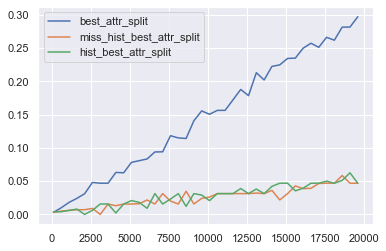

In [545]:
def plot_performance_scaling_test(size_samples, functions, has_nan = False, **kwargs):
    times = {func.__name__ : [] for func in functions}
    res = {func.__name__ : [] for func in functions}
    for i in range(100, 20000, 500):
        size_sample = i
        dur = np.random.uniform(0, 10000, size_sample)
        cens = np.random.choice(2, size_sample)
        vals = np.random.uniform(100, 8000, size_sample)
        if has_nan:
            nan_index = np.random.uniform(0, 1, size_sample) < 0.25
            vals[nan_index] = np.nan
        arr = np.vstack([vals, cens, dur])
        
        for func in functions:
            time_start = time.time()
            res[func.__name__].append(func(arr, **kwargs))
            times[func.__name__].append(time.time() - time_start)
    
    for func in functions:
        plt.plot(size_samples, times[func.__name__], label = func.__name__)
    plt.legend()
    return times, res
    
_, _ = plot_performance_scaling_test(range(100, 20000, 500), 
                              [best_attr_split, 
                               miss_hist_best_attr_split, 
                               hist_best_attr_split])

In [491]:
np.all([r1['min_split'] == r2['min_split'] for r1, r2 in zip(res_hist, res_old)])

True

### Тестирование

In [510]:
dur = np.random.uniform(0, 10000, 9600)
cens = np.random.choice(2, 9600)
vals = np.random.uniform(100, 8000, 9600)
# nan_index = np.random.uniform(0, 1, 9600) < 0.15
# vals[nan_index] = np.nan

arr = np.vstack([vals, cens, dur])

In [514]:
best_attr_split(arr)

{'stat_val': 1.77879798412323,
 'values': [' >= 3570.749', ' < 3570.749'],
 'pos_nan': [1, 0],
 'min_split': 4224,
 'p_value': 18.047402639352676,
 'sign_split': 99}

In [515]:
miss_hist_best_attr_split(arr)

{'stat_val': 1.77879798412323,
 'values': [' <= 3570.749', ' > 3570.749'],
 'pos_nan': [1, 0],
 'min_split': 4224,
 'p_value': 18.047402639352676,
 'sign_split': 99}

In [516]:
hist_best_attr_split(arr)

{'stat_val': 1.77879798412323,
 'values': [' <= 3570.749', ' > 3570.749'],
 'pos_nan': [1, 0],
 'min_split': 4224,
 'p_value': 18.047402639352676,
 'sign_split': 99}

In [506]:
profiler = cProfile.Profile()
profiler.enable()
miss_hist_best_attr_split(arr)
profiler.disable()
stats_ = pstats.Stats(profiler).sort_stats('cumtime')
stats_.print_stats()
stats_.dump_stats('miss.pstats')

         2933 function calls (2921 primitive calls) in 0.027 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    0.027    0.014 C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\IPython\core\interactiveshell.py:3362(run_code)
        2    0.000    0.000    0.027    0.014 {built-in method builtins.exec}
        1    0.000    0.000    0.027    0.027 C:\Users\vasiliev\AppData\Local\Temp\ipykernel_1692\3010859083.py:1(<cell line: 3>)
        1    0.006    0.006    0.027    0.027 C:\Users\vasiliev\AppData\Local\Temp\ipykernel_1692\497725815.py:12(miss_hist_best_attr_split)
       99    0.000    0.000    0.015    0.000 C:\Users\vasiliev\AppData\Local\Temp\ipykernel_1692\2844478352.py:48(optimal_criter_split_hist)
       99    0.000    0.000    0.015    0.000 C:\Users\vasiliev\AppData\Local\Temp\ipykernel_1692\2844478352.py:45(logrank_hist)
       99    0.001    0.000    0.015    0.000 C:\Users\v

In [507]:
profiler = cProfile.Profile()
profiler.enable()
hist_best_attr_split(arr)
profiler.disable()
stats_ = pstats.Stats(profiler).sort_stats('cumtime')
stats_.print_stats()
stats_.dump_stats('hist.pstats')

         2942 function calls (2930 primitive calls) in 0.031 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    0.031    0.015 C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\IPython\core\interactiveshell.py:3362(run_code)
        2    0.000    0.000    0.031    0.015 {built-in method builtins.exec}
        1    0.000    0.000    0.031    0.031 C:\Users\vasiliev\AppData\Local\Temp\ipykernel_1692\2156552009.py:1(<cell line: 3>)
        1    0.006    0.006    0.031    0.031 C:\Users\vasiliev\AppData\Local\Temp\ipykernel_1692\622210976.py:1(hist_best_attr_split)
       99    0.000    0.000    0.015    0.000 C:\Users\vasiliev\AppData\Local\Temp\ipykernel_1692\2844478352.py:48(optimal_criter_split_hist)
       99    0.000    0.000    0.015    0.000 C:\Users\vasiliev\AppData\Local\Temp\ipykernel_1692\2844478352.py:45(logrank_hist)
       99    0.001    0.000    0.015    0.000 C:\Users\vasilie

In [508]:
profiler = cProfile.Profile()
profiler.enable()
best_attr_split(arr)
profiler.disable()
stats_ = pstats.Stats(profiler).sort_stats('cumtime')
stats_.print_stats()
stats_.dump_stats('best_old.pstats')

         2351 function calls (2342 primitive calls) in 0.145 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    0.145    0.073 C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\IPython\core\interactiveshell.py:3362(run_code)
        2    0.000    0.000    0.145    0.073 {built-in method builtins.exec}
        1    0.000    0.000    0.145    0.145 C:\Users\vasiliev\AppData\Local\Temp\ipykernel_1692\769146453.py:1(<cell line: 3>)
        1    0.000    0.000    0.145    0.145 C:\Users\vasiliev\AppData\Local\Temp\ipykernel_1692\2125328076.py:72(best_attr_split)
        1    0.012    0.012    0.144    0.144 C:\Users\vasiliev\AppData\Local\Temp\ipykernel_1692\2125328076.py:31(get_cont_attrs)
       99    0.000    0.000    0.127    0.001 C:\Users\vasiliev\AppData\Local\Temp\ipykernel_1692\2125328076.py:1(optimal_criter_split)
       99    0.000    0.000    0.127    0.001 C:\Users\vasiliev\AppDat

### Тестирование WOE

In [529]:
dur_woe = np.random.uniform(0, 10000, 10000)
cens_woe = np.random.choice(2, 10000)
vals_woe = np.random.choice(10, 10000)
# nan_index = np.random.uniform(0, 1, 9600) < 0.15
# vals[nan_index] = np.nan

arr_woe = np.vstack([vals_woe, cens_woe, dur_woe])

In [531]:
arr_woe

array([[6.00000000e+00, 2.00000000e+00, 4.00000000e+00, ...,
        3.00000000e+00, 8.00000000e+00, 4.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [5.56504167e+03, 1.58268890e+03, 9.89469365e+03, ...,
        1.06301344e+02, 3.49488136e+03, 9.79036062e+03]])

In [535]:
%timeit best_attr_split(arr_woe, type_attr="woe")

22.4 ms ± 216 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [536]:
%timeit miss_hist_best_attr_split(arr_woe, type_attr="woe")

12.7 ms ± 42.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
